The dataset has 8 folders, one for each class of images. Let's verify this by printing the folder names using `os.listdir`

In [1]:
import os

dataset_path = './Micro_Organism'

print(os.listdir(dataset_path))

['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


Now, we can look at the each folder to see how many images each has.

In [2]:
for folder in os.listdir(dataset_path):
    folder_path = os.listdir(dataset_path + '/' + folder.capitalize())
    print('Number of images for', folder, '=>', len(folder_path))

Number of images for Amoeba => 72
Number of images for Euglena => 168
Number of images for Hydra => 76
Number of images for Paramecium => 152
Number of images for Rod_bacteria => 85
Number of images for Spherical_bacteria => 86
Number of images for Spiral_bacteria => 75
Number of images for Yeast => 75


Then, we can use the `ImageFolder` from `torchvision` to load the data as tensors.

Since the images has different shapes we need to resize them. Additionally, to make the training process more efficient we normalize the data.

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Normalize

transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)

I had to use a 32x32 tensor to overcome the following error. Using a higher pixel density tensors was making my GPU to fail in terms memory.

`OutOfMemoryError: CUDA out of memory. Tried to allocate 3.06 GiB (GPU 0; 8.00 GiB total capacity; 5.35 GiB already allocated; 285.77 MiB free; 5.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF`

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
print(len(dataset))

789


Our dataset has 789 images, so let's use this number to show a couple of images.

Be aware that these are normalized versions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Amoeba 0


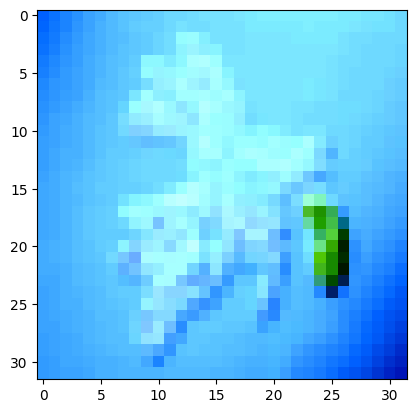

In [5]:
def show_example(img, label):
  print('Label:', dataset.classes[label], label)
  plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Yeast 7


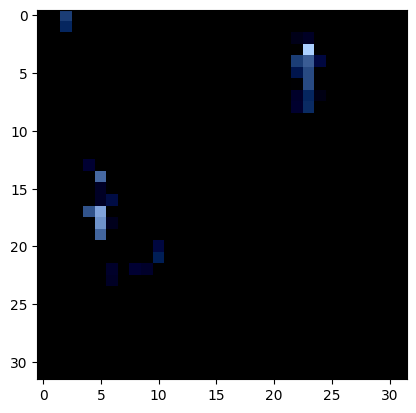

In [6]:
show_example(*dataset[788])

Now, let's split the data accordingly using a random seed.

Our training set will consist of 400 images and validation set will consist of 160 images. The rest will be our test set.

In [7]:
import torch
from torch.utils.data import random_split

torch.manual_seed(42)
train_size = 400
val_size = 160
test_size = len(dataset) - (train_size + val_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('Train Dataset Len:', len(train_dataset))
print('Validation Dataset Len:', len(validation_dataset))
print('Test Dataset Len:', len(test_dataset))

Train Dataset Len: 400
Validation Dataset Len: 160
Test Dataset Len: 229


Let's make sure that the validation and test sets includes at least 10 images per class.

In [8]:
def count_labels(dataset_subset, dataset_targets, num_classes):
    indices = dataset_subset.indices
    labels = [dataset_targets[i] for i in indices]
    counts = [labels.count(i) for i in range(num_classes)]
    return counts

num_classes = 8

labels = dataset.targets

train_counts = count_labels(train_dataset, labels, num_classes)
val_counts = count_labels(validation_dataset, labels, num_classes)
test_counts = count_labels(test_dataset, labels, num_classes)

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)
print("Test set class distribution:", test_counts)


Training set class distribution: [33, 82, 33, 78, 47, 46, 42, 39]
Validation set class distribution: [15, 32, 10, 35, 17, 17, 18, 16]
Test set class distribution: [24, 54, 33, 39, 21, 23, 15, 20]


Now, we can create data loaders for training and validation to load the data in batches.

1. `num_workers` enables parallel data loading to improve the loading speed. The number will determine the number of CPU cores that will be used.
2. `pin_memory` enables faster data transfer to GPU memory.

In [9]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size * 2, num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size * 2, num_workers = 4, pin_memory = True)

We can show a batch from training dataloader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


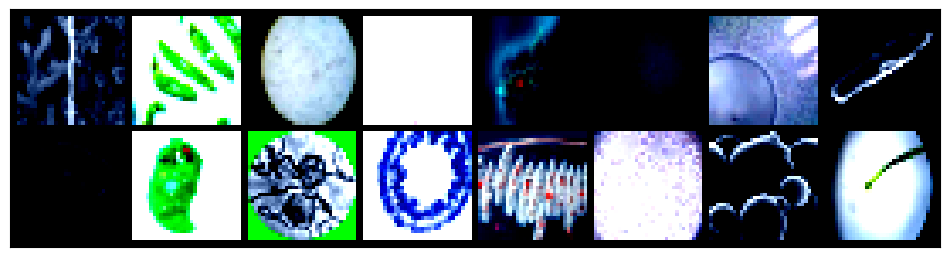

In [10]:
from torchvision.utils import make_grid

def show_batch(dataloader):
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
    break

show_batch(train_dataloader)

The `conv2d` later transforms a 3-channel image to a 16-channel feature map.

The `MaxPool2d` layer reduces the height and the width to half.

The feature map gets smaller with each layer added, the goal is to have a flattened vector. After that, we can add some fully connected layers.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    # Generate predictions
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'validation_loss': loss.detach(), 'validation_accuracy': acc} 

  def validation_epoch_end(self, outputs):
      batch_losses = [x['validation_loss'] for x in outputs]
      # Combine losses
      epoch_loss = torch.stack(batch_losses).mean()
      batch_accs = [x['validation_accuracy'] for x in outputs]
      # Combine accuracies
      epoch_acc = torch.stack(batch_accs).mean()
      return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      train_loss, val_loss, val_acc = result['train_loss'], result['validation_loss'], result['validation_accuracy']
      print(f"Epoch [{epoch}/100], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

`nn.Conv2D(3, 32, kernel_size=3, padding=1)` creates a 2D convolutional layer.

1. 3 is the number of input channels (RGB)
2. 32 is the number of output channels. This means that there will be 32 feature maps
3. kernel_size=3 specifies the size of the conv kernel
4. padding=1 specifies the amount of zero-padding around the input image before applying the conv.

`nn.MaxPool2d(2,2)` is the max-pooling layer in our model. It reduces the spatial dimensions of feature maps while keeping important information.

1. The first number 2 is the size of the kernel for the max-pooling operation.
2. The second number 2 is the stride. This number determines how much the max-pooling window moves between each iteration.

`nn.ReLU()` is a activation non-linear activation function. It's basically:

`f(x) = max(0, x)`

It helps to generate non-linearity to model which will help it to learn complex patterns.

`nn.Flatten()` flattens the tensor into a 1D tensor.
`nn.Linear(256 * 112 * 112, 1024)` is a fully connected linear layer. The first parameter is the input size while the second parameter 1024 is the output size.

In [12]:
class CNNModel(ImageClassificationModel):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 8))
        
    def forward(self, xb):
        return self.network(xb)


model = CNNModel()
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=32768, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256, out_features=8, bias=True)
  )
)

We can use a GPU in PyTorch to make the calculations more efficient.

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        print('Using CUDA')
        return torch.device('cuda')
    else:
        print('Using CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataloader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
device

Using CUDA


device(type='cuda')

In [14]:
train_dataloader = DeviceDataloader(train_dataloader,  device)
validation_dataloader = DeviceDataloader(validation_dataloader, device)
test_dataloader = DeviceDataloader(test_dataloader, device)

Now, we can train the model by firstly defining two functions: `fit` and `evaluate`

In [15]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, validation_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = to_device(model, device)
evaluate(model, validation_dataloader)

{'validation_loss': 2.0842063426971436, 'validation_accuracy': 0.09375}

The initial accuracy is around 10%, it's good accuracy given that it has 1 in 8 chance in random.

**Hyperparameters**

In [17]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [18]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func)

Epoch [0/100], Training Loss: 2.0629, Validation Loss: 2.0095, Validation Accuracy: 0.2313
Epoch [1/100], Training Loss: 2.0241, Validation Loss: 2.0128, Validation Accuracy: 0.2500
Epoch [2/100], Training Loss: 2.0151, Validation Loss: 2.0338, Validation Accuracy: 0.1875
Epoch [3/100], Training Loss: 2.0087, Validation Loss: 1.9044, Validation Accuracy: 0.2562
Epoch [4/100], Training Loss: 1.9790, Validation Loss: 2.0116, Validation Accuracy: 0.2188
Epoch [5/100], Training Loss: 1.9478, Validation Loss: 1.9203, Validation Accuracy: 0.2688
Epoch [6/100], Training Loss: 1.9331, Validation Loss: 1.8641, Validation Accuracy: 0.2875
Epoch [7/100], Training Loss: 1.8479, Validation Loss: 1.8880, Validation Accuracy: 0.2812
Epoch [8/100], Training Loss: 1.8666, Validation Loss: 1.8432, Validation Accuracy: 0.2875
Epoch [9/100], Training Loss: 1.7994, Validation Loss: 1.7808, Validation Accuracy: 0.3688
Epoch [10/100], Training Loss: 1.7849, Validation Loss: 1.8102, Validation Accuracy: 0.350

**This is a poor first attempt.**

The model seems to be overfitting as the training loss is getting lower but the validation loss is getting higher.

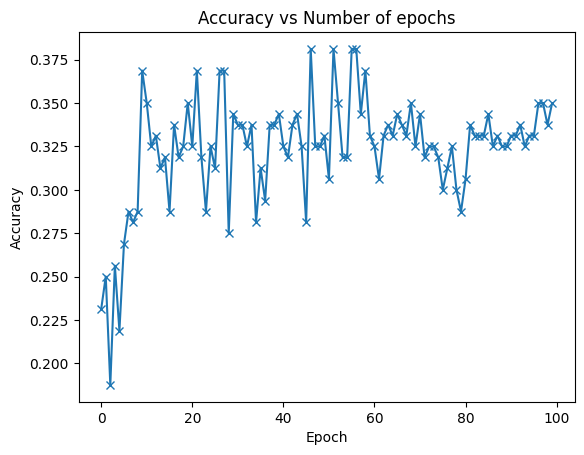

In [19]:
def plot_accuracies(history):
    accuracies = [x['validation_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of epochs')

plot_accuracies(history)

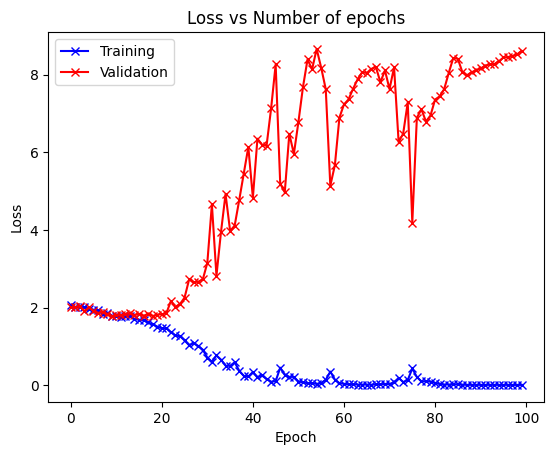

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Number of epochs')

plot_losses(history)

If we take the point `Epoch [9/100], Training Loss: 1.7994, Validation Loss: 1.7808, Validation Accuracy: 0.3688` as the point where validation loss goes higher while training loss drops, then our accuracy can be considered as `36%`

Check `image_classification.ipynb`